Uwaga! wykresy zostały wygenerowane przy pomocy chatGPT, zeby jak najbardziej moc sie skupic na teoretycznych aspektach zadań

## P4.7

In this task we have to focuse on above social networks metrics: 
* type of graph
* number of nodes
* number of edges
* average degree of node, where k = 2E/N
* clustering coefficient (measures how much nodes form triangles — i.e., to what extent my friends' friends are also my friends)
* average shortest path length
* assortativity coefficient (measures whether nodes with similar degrees tend to connect with each other)

Note: when we chooses networks, we focuse on their size (in therms of storage space), cause I have really small amout of available storage in computer. Also we try to choose networks from diffrent categories

In [1]:
# ============================================
# Network Metrics Comparison
# Zachary’s Karate Club | Dolphins | Yeast PPI | US Power Grid
# ============================================

import networkx as nx
import pandas as pd
import urllib.request
import os
from scipy.io import mmread 

# --------------------------------------------
# 1️⃣ Load networks
# --------------------------------------------

# Built-in (NetworkX)
karate = nx.karate_club_graph()



# Read .mtx as adjacency matrices and convert to graphs
dolphins_adj = mmread("soc-dolphins.mtx").tocsr()
dolphins = nx.from_scipy_sparse_array(dolphins_adj)

def load_yeast_mtx(filename):
    edges = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line.startswith('%'):
                continue  # skip header/comment
            # split line into numbers
            nums = list(map(int, line.split()))
            if len(nums) >= 2:
                edges.append((nums[0], nums[1]))  # first two numbers are edge
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

yeast = load_yeast_mtx("bio-yeast.mtx")
print(f"✅ Loaded Yeast network with {yeast.number_of_nodes()} nodes and {yeast.number_of_edges()} edges")


powergrid_adj = mmread("power-US-Grid.mtx").tocsr()
powergrid = nx.from_scipy_sparse_array(powergrid_adj)


# --------------------------------------------
# 2️⃣ Define function to compute metrics
# --------------------------------------------
def compute_metrics(G, name):
    N = G.number_of_nodes()
    E = G.number_of_edges()
    avg_k = 2 * E / N if not G.is_directed() else sum(dict(G.degree()).values()) / N
    alpha = nx.average_clustering(G)
    
    # Compute average shortest path length only if connected
    if nx.is_connected(G.to_undirected()):
        ell = nx.average_shortest_path_length(G)
    else:
        largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
        G_sub = G.subgraph(largest_cc)
        ell = nx.average_shortest_path_length(G_sub)
    
    r = nx.degree_assortativity_coefficient(G)
    
    return {
        "Network’s name": name,
        "↔?": "Directed" if G.is_directed() else "Undirected",
        "N": N,
        "E": E,
        "⟨k⟩": round(avg_k, 3),
        "α": round(alpha, 3),
        "ℓ": round(ell, 3),
        "r": round(r, 3)
    }


# --------------------------------------------
# 3️⃣ Compute metrics for all
# --------------------------------------------
networks = [
    ("Zachary’s Karate Club", karate),
    ("Dolphins", dolphins),
    ("Yeast Protein Interaction Network", yeast),
    ("US Power Grid", powergrid)
]

results = [compute_metrics(G, name) for name, G in networks]

# --------------------------------------------
# 4️⃣ Create and print results table
# --------------------------------------------
df = pd.DataFrame(results)
print("\n📊 Network Metrics Summary:\n")
print(df.to_string(index=False))

# --------------------------------------------
# 5️⃣ Save to CSV (optional)
# --------------------------------------------
df.to_csv("network_metrics_summary.csv", index=False)
print("\n✅ Results saved to 'network_metrics_summary.csv'")


✅ Loaded Yeast network with 1458 nodes and 1949 edges

📊 Network Metrics Summary:

                   Network’s name         ↔?    N    E   ⟨k⟩     α      ℓ      r
            Zachary’s Karate Club Undirected   34   78 4.588 0.571  2.408 -0.476
                         Dolphins Undirected   62  159 5.129 0.259  3.357 -0.044
Yeast Protein Interaction Network Undirected 1458 1949 2.674 0.071  6.812 -0.210
                    US Power Grid Undirected 4941 6594 2.669 0.080 18.989  0.003

✅ Results saved to 'network_metrics_summary.csv'


Let's draw graphs of these networks to see how the metrics reflect their appearance.

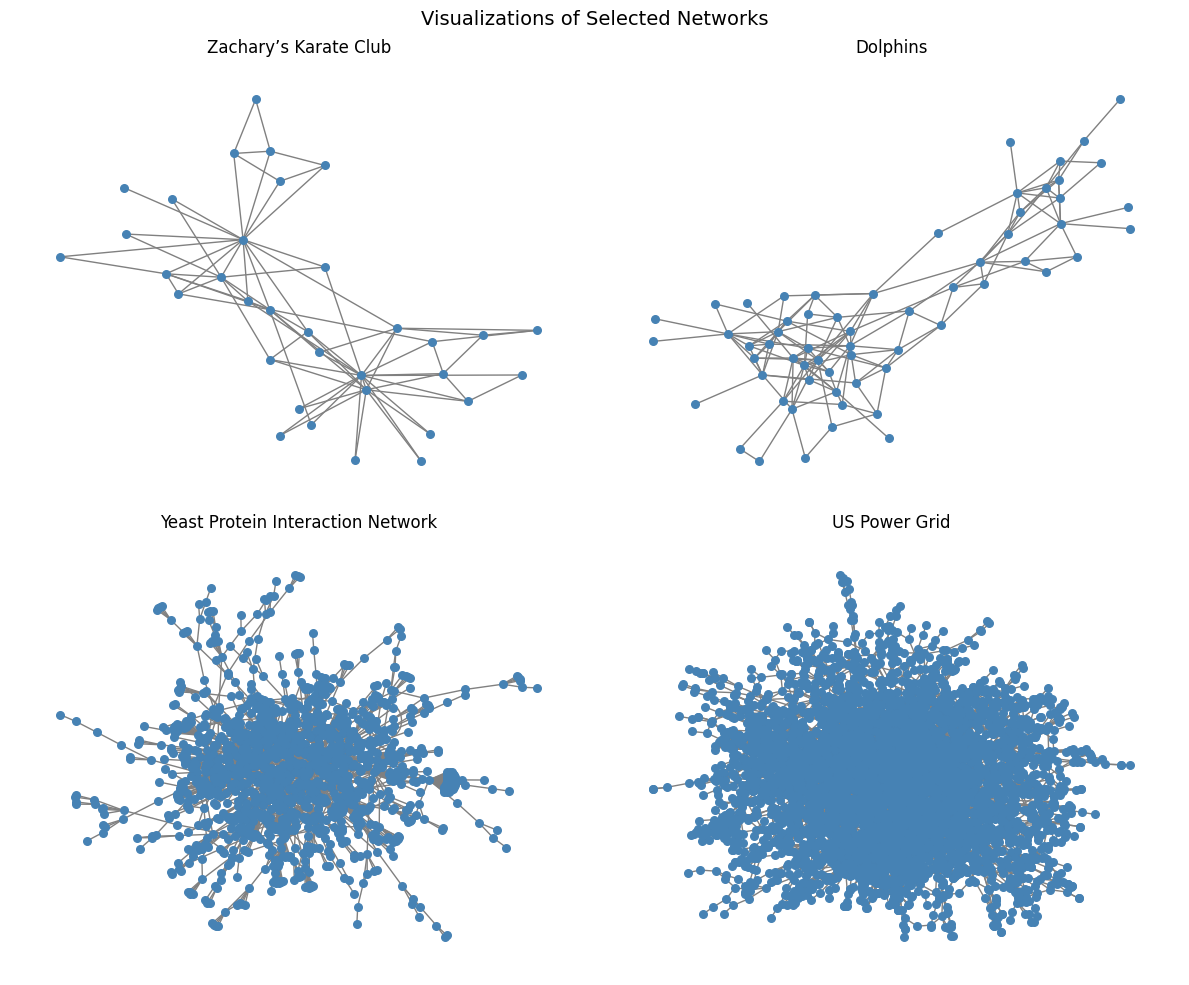

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, G) in zip(axes, networks):
    pos = nx.spring_layout(G, seed=42)  # ładny układ w 2D
    nx.draw(
        G,
        pos,
        ax=ax,
        node_size=30,
        edge_color='gray',
        node_color='steelblue',
        with_labels=False
    )
    ax.set_title(name)

plt.suptitle("Visualizations of Selected Networks", fontsize=14)
plt.tight_layout()
plt.show()


Now, we will consider task, that focuses on examination of structure represented by rael word case - examination of people connected to one exact person, and people who knows people who knows that exact person

Firstly, let's examine Erdos number - it measures how “collaboratively close” a researcher is to the prolific mathematician Paul Erdős based on co-authorship of research papers

📊 Nobel Prize winners:
count    320.000000
mean       5.256250
std        1.762539
min        2.000000
25%        4.000000
50%        5.000000
75%        6.000000
max       12.000000
Name: ErdosNumber, dtype: float64 

📊 Fields Medalists:
count    63.000000
mean      3.142857
std       0.858678
min       2.000000
25%       2.500000
50%       3.000000
75%       4.000000
max       5.000000
Name: ErdosNumber, dtype: float64 



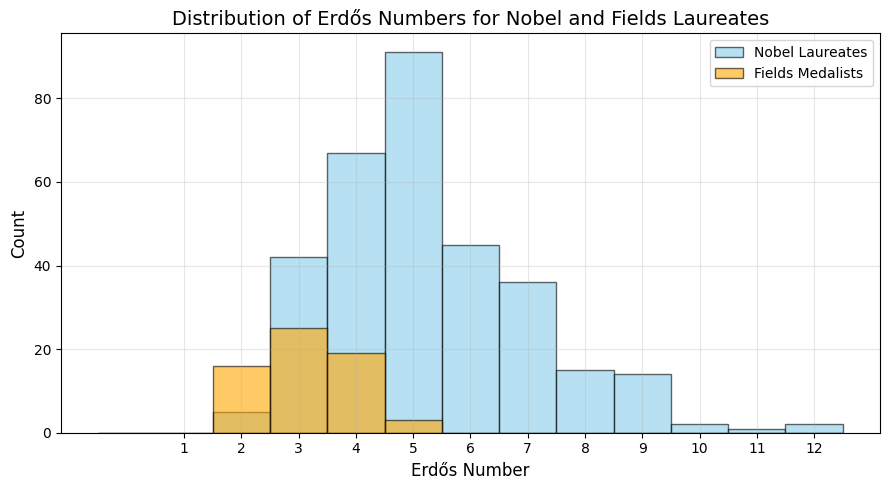

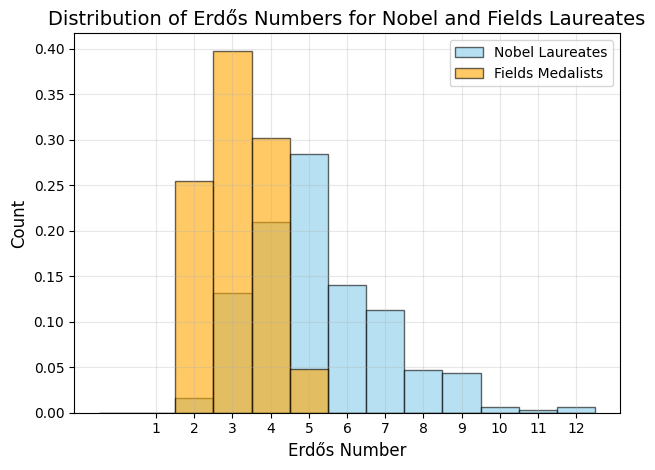

🏅 Nobel laureate with highest Erdős number: Jack St. Clair Kilby (12.0)
🎓 Fields medalist with highest Erdős number: Paul Cohen (5.0)


In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------
# 1️⃣ Load data
# --------------------------------------------
nobels = pd.read_csv("nobels.txt", sep=r"\s{2,}", engine="python", header=None)
fields = pd.read_csv("fields.txt", sep=r"\s{2,}", engine="python", header=None)

# Fix column names
nobels.columns = ["Name", "Year", "Discipline", "ErdosNumber"]
fields.columns = ["Name", "Year", "Country", "ErdosNumber"]

# Convert last column to numeric
nobels["ErdosNumber"] = pd.to_numeric(nobels["ErdosNumber"], errors="coerce")
fields["ErdosNumber"] = pd.to_numeric(fields["ErdosNumber"], errors="coerce")

# --------------------------------------------
# 2️⃣ Quick statistics
# --------------------------------------------
print("📊 Nobel Prize winners:")
print(nobels["ErdosNumber"].describe(), "\n")

print("📊 Fields Medalists:")
print(fields["ErdosNumber"].describe(), "\n")

# --------------------------------------------
# 3️⃣ Draw normalized histograms (in percent range)
# --------------------------------------------
plt.figure(figsize=(9,5))

bins = range(0, int(max(nobels["ErdosNumber"].max(), fields["ErdosNumber"].max())) + 2)

plt.hist(nobels["ErdosNumber"], bins=bins, alpha=0.6, label="Nobel Laureates", color="skyblue", edgecolor="black")
plt.hist(fields["ErdosNumber"], bins=bins, alpha=0.6, label="Fields Medalists", color="orange", edgecolor="black")

plt.xlabel("Erdős Number", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Erdős Numbers for Nobel and Fields Laureates", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# ✅ Put ticks at integer centers
plt.xticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5], ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])

plt.tight_layout()
plt.show()

plt.hist(nobels["ErdosNumber"], bins=bins, alpha=0.6, label="Nobel Laureates",
         color="skyblue", edgecolor="black", density=True)
plt.hist(fields["ErdosNumber"], bins=bins, alpha=0.6, label="Fields Medalists",
         color="orange", edgecolor="black", density=True)

plt.xlabel("Erdős Number", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Erdős Numbers for Nobel and Fields Laureates", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# ✅ Put ticks at integer centers
plt.xticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5], ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])

plt.tight_layout()
plt.show()

# --------------------------------------------
# 4️⃣ Who has the highest Erdős number?
# --------------------------------------------
nobel_max = nobels.loc[nobels["ErdosNumber"].idxmax()]
fields_max = fields.loc[fields["ErdosNumber"].idxmax()]

print(f"🏅 Nobel laureate with highest Erdős number: {nobel_max['Name']} ({nobel_max['ErdosNumber']})")
print(f"🎓 Fields medalist with highest Erdős number: {fields_max['Name']} ({fields_max['ErdosNumber']})")


Secondly, we examine the network of connection between actor Kevin Bacon and actors / actress who won Nobel prize

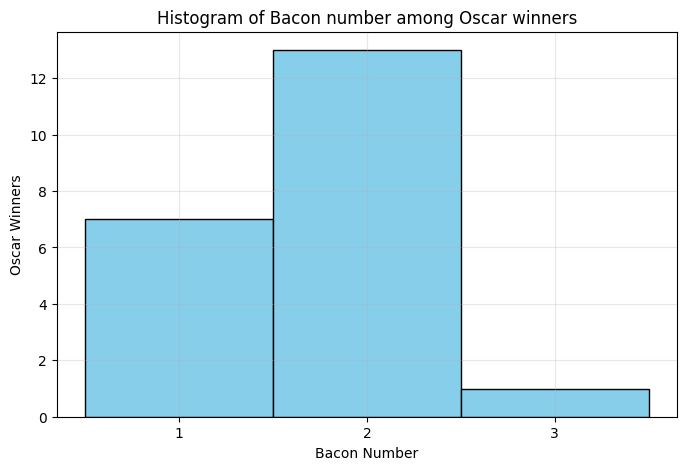

Actor/ Actress with max Bacon number is: Mary Pickford (3). She played a role of Norma Besant in 'Coquette' from 1928/29.


In [51]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Actor": [
        "Adrien Brody ", "Cillian Murphy", "Brendan Fraser",
        "Will Smith", "Anthony Hopkins", "Joaquin Phoenix",
        "Rami Malek",
        "Mikey Madison", "Emma Stone", "Michelle Yeoh",
        "Jessica Chastain", "Frances McDormand", "Renée Zellweger",
        "Olivia Colman",
        "Frances McDormand", "Brie Larson", "Julianne Moore",
        "Gary Oldman", "Casey Affleck", "Colin Firth", "Mary Pickford"
    ],
    "Bacon Number": [2, 2, 1, 2, 2, 2, 
                     2,
                     2, 1, 2, 
                     2, 2, 1, 2,
                     2, 2, 1,
                     1, 1, 1, 3]
                         # wpisz własne wyniki z Oracle of Bacon
}

df = pd.DataFrame(data)

# Rysujemy histogram
plt.figure(figsize=(8,5))
plt.hist(df["Bacon Number"], bins=range(1, df["Bacon Number"].max()+2), 
         color="skyblue", edgecolor='black', alpha=1)
tick_positions = np.arange(1, df["Bacon Number"].max() + 1)
plt.xticks([1.5, 2.5, 3.5], ["1", "2", "3"])
plt.xlabel("Bacon Number")
plt.ylabel("Oscar Winners")
plt.title("Histogram of Bacon number among Oscar winners")
plt.grid(alpha=0.3)
plt.show()

# Wypisz aktora z największym numerem
max_bacon = df.loc[df["Bacon Number"].idxmax()]
print(f"Actor/ Actress with max Bacon number is: {max_bacon['Actor']} ({max_bacon['Bacon Number']}). She played a role of Norma Besant in 'Coquette' from 1928/29.")


5